In [20]:
# Actualizar ciervo
! pip install ciervo --upgrade

In [21]:

from ciervo.plots import emg_plot
from ciervo.io import example_marcha


from scipy import signal
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import numpy as np


# Classifiers
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold






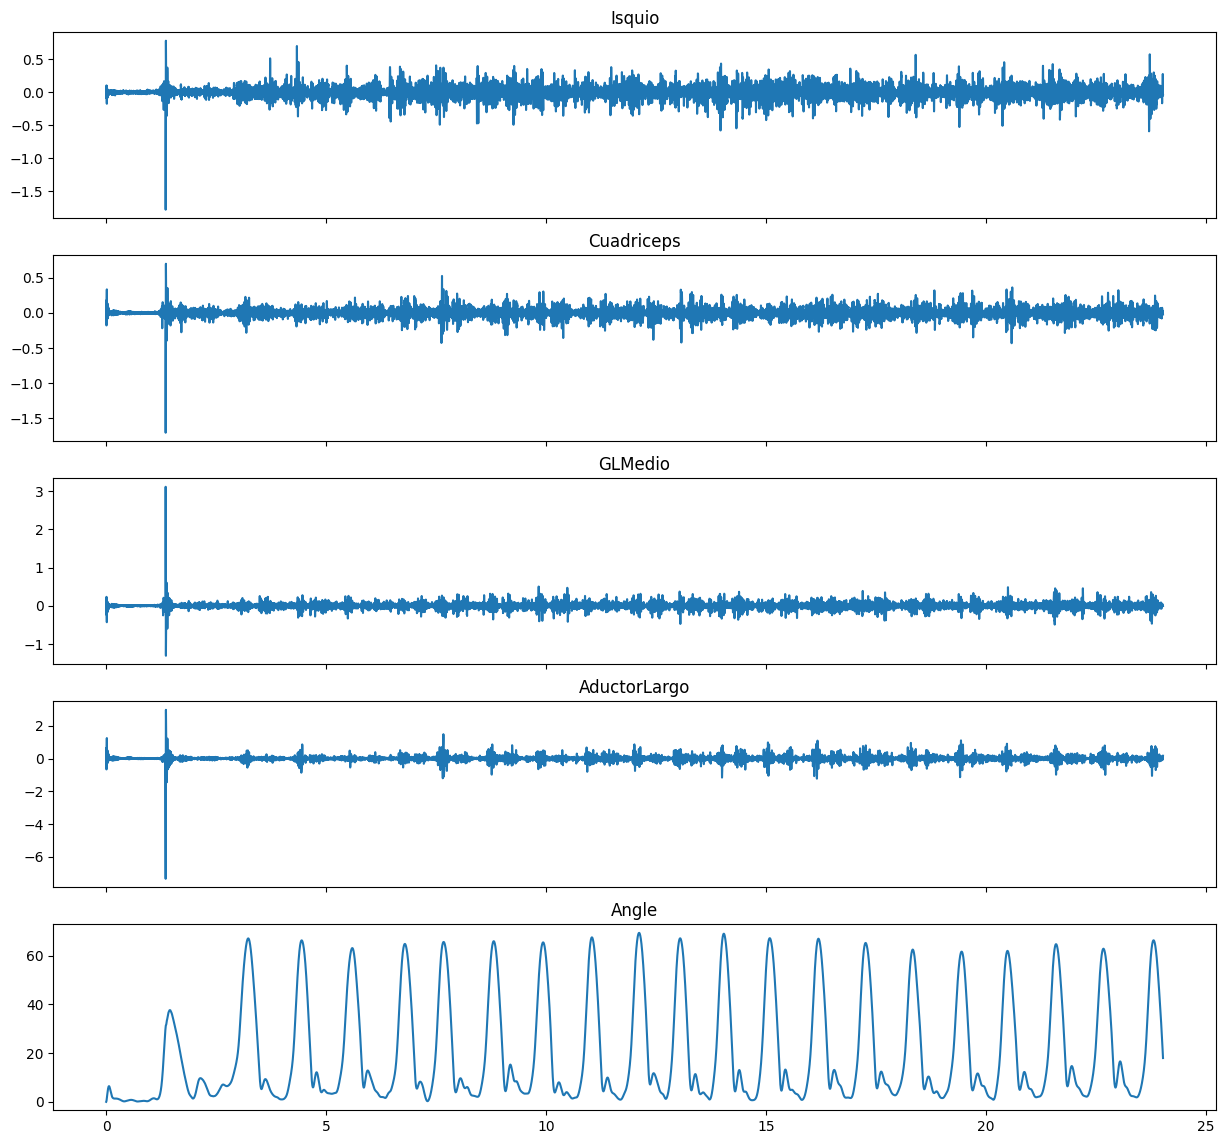

In [22]:
data  = example_marcha()[0] # data es un dataframe
emg_plot(data)


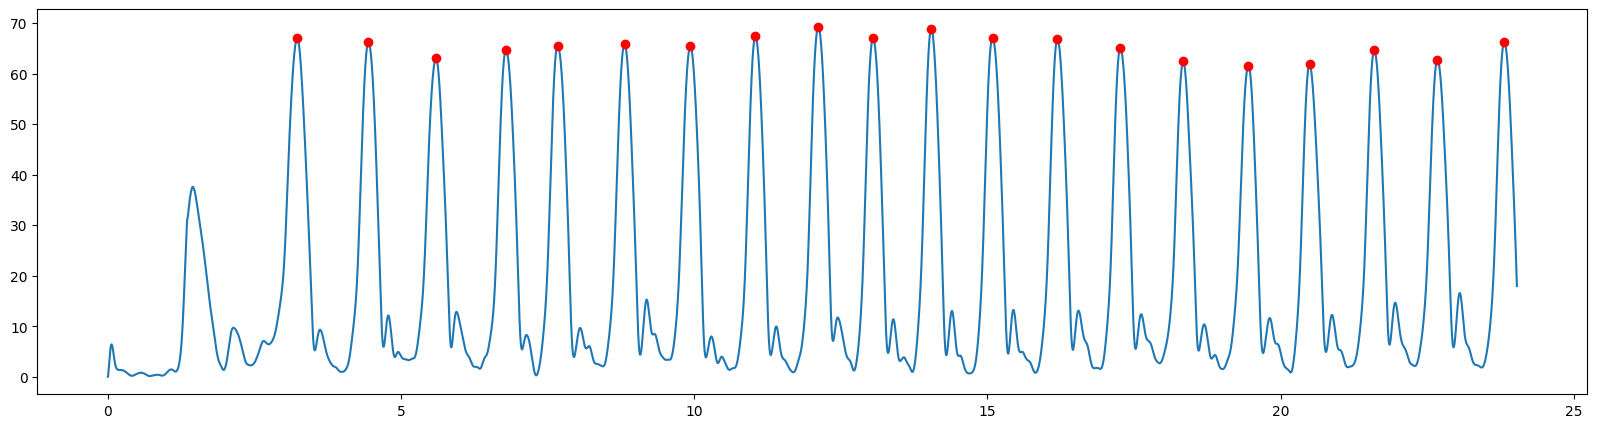

In [23]:
peaks = find_peaks(data['Angle'], height=50, distance=500, width=20)
fig = plt.figure(figsize=(20, 5))
plt.plot(data['Elapsed Time'], data['Angle'])
plt.plot(peaks[0]/1000, data['Angle'][peaks[0]], 'ro') 


/var/folders/yx/lr9k5kc529b8ksstx9_p3nkr0000gn/T/ipykernel_34772/1833505993.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


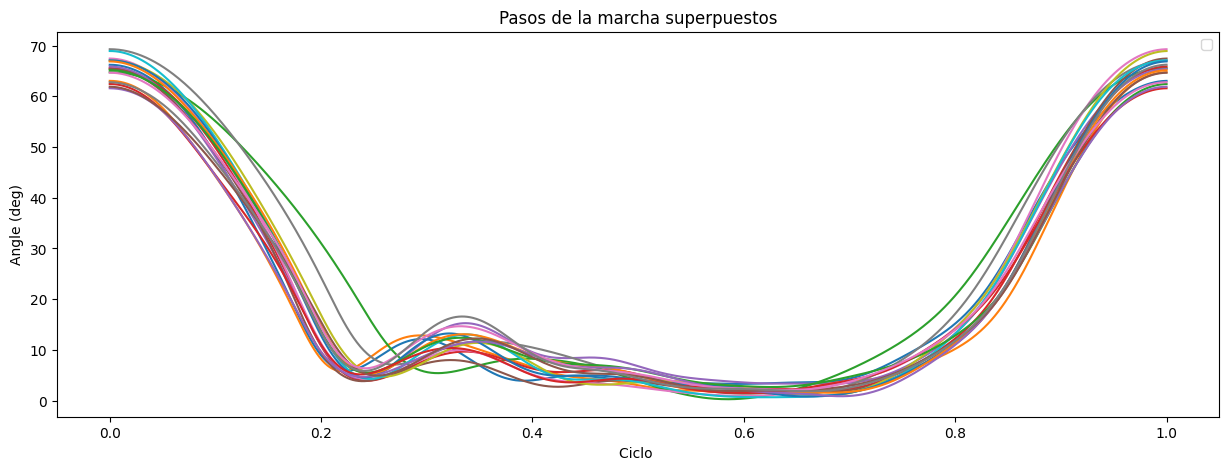

In [24]:
step = []
for i in range(1, len(peaks[0])-1):
    step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))   


fig = plt.figure(figsize=(15, 5))
for i in range(len(step)):
    t = np.linspace(0, 1, len(step[i]))
    plt.plot(t, step[i])

plt.xlabel('Ciclo ')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('Pasos de la marcha superpuestos')

plt.show()


# Clasificación

In [25]:
#### Extract features #####
muscles = data.columns[1:-1]

# Divide by steps
step = []
emg = []
file = []
for index, data in enumerate(example_marcha()):

    # peaks
    peaks = find_peaks(data['Angle'], height=50, distance=500, width=20)
    for i in range(1, len(peaks[0])-1):
        step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))
        emg_window = data[muscles][peaks[0][i]:peaks[0][i+1]].reset_index(drop=True)
        emg_window = np.array(emg_window)

        # normalize
        emg_window = (emg_window - emg_window.mean())/emg_window.std()
        emg.append(emg_window) # un paso normalizado de la marcha
        file.append(index) # archivo al que pertenece el paso
file = np.array(file)



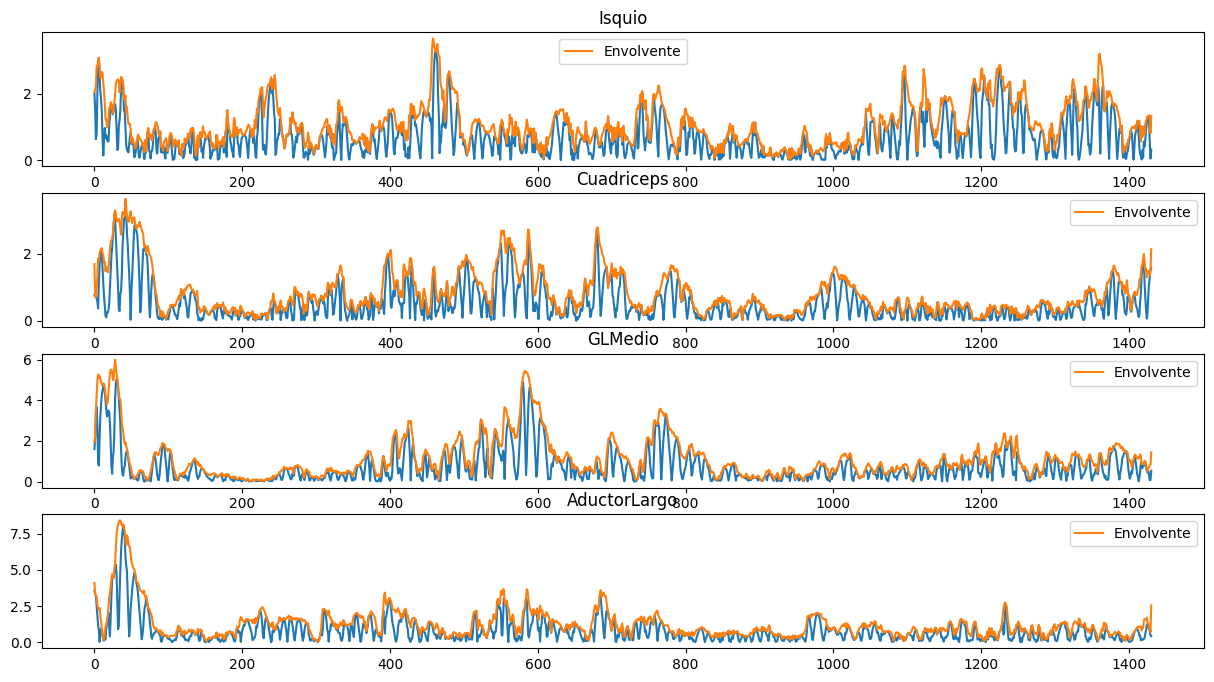

In [26]:
fig,ax = plt.subplots(4, 1, figsize=(15, 8))
for i in range(4):

    ax[i].plot(np.abs(emg_window[:, i]))  # Señal con full wave rectification 
    
    # Calculo de la envolvente
    env = np.abs(signal.hilbert(emg_window[:, i]))
    ax[i].plot(env, label='Envolvente')
    ax[i].set_title(muscles[i])
    ax[i].legend()

plt.show()


In [27]:
import seaborn as sns
import pandas as pd

# Extract features #
def extract_feature(data, C=[0], divide=3):
    # Full wave rectification
    # data : (T, 4) 

    divide= divide
    result = []
    for c in C:
        env = np.abs(signal.hilbert(data[:, c]))
        for i in range(divide):
            start = int(i*len(data)/divide)
            end = int((i+1)*len(data)/divide)
            promedio  =env[start:end].mean()
            result.append(promedio)
    result = np.array(result)
    
    return result

def label_data_and_features(data, C= [0, 1, 2, 3], divide=3):
    features = []
    labels = []
    for e in data:
        T, _ = e.shape
        for i in range(num_fases):
            start = int(i*T/num_fases)
            end = int((i+1)*T/num_fases)
            features.append(extract_feature(e[start:end, :], C=C, divide=divide))
            labels.append(i)

    features = np.array(features)
    labels = np.array(labels)
    return features, labels

num_fases = 8
divide = 4  # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [1, 2, 3]  # Canales a utilizar -> Cuadriceps, GLMedio y Aductor largo


# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels = label_data_and_features(emg[:np.sum(file != 16)], C, divide)
test_data, test_labels = label_data_and_features(emg[np.sum(file != 16):], C, divide)

# Feature selection
# Selecciona las características que tienen una varianza mayor a un umbral
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
train_data = sel.fit_transform(train_data)
test_data = sel.transform(test_data)








SVC 0.7013888888888888


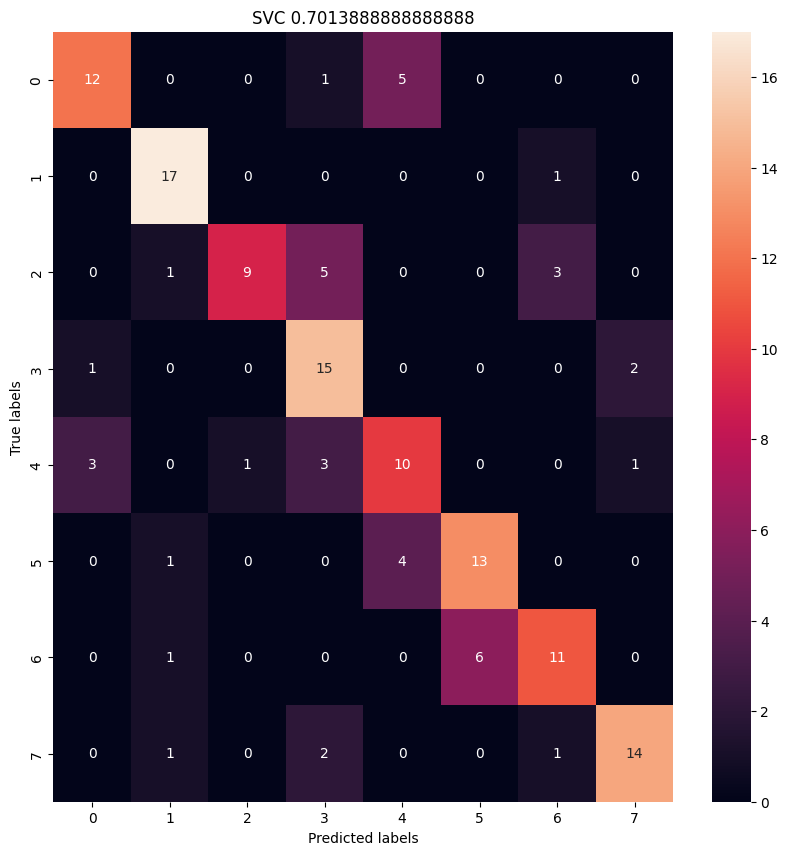

MLPClassifier 0.6944444444444444


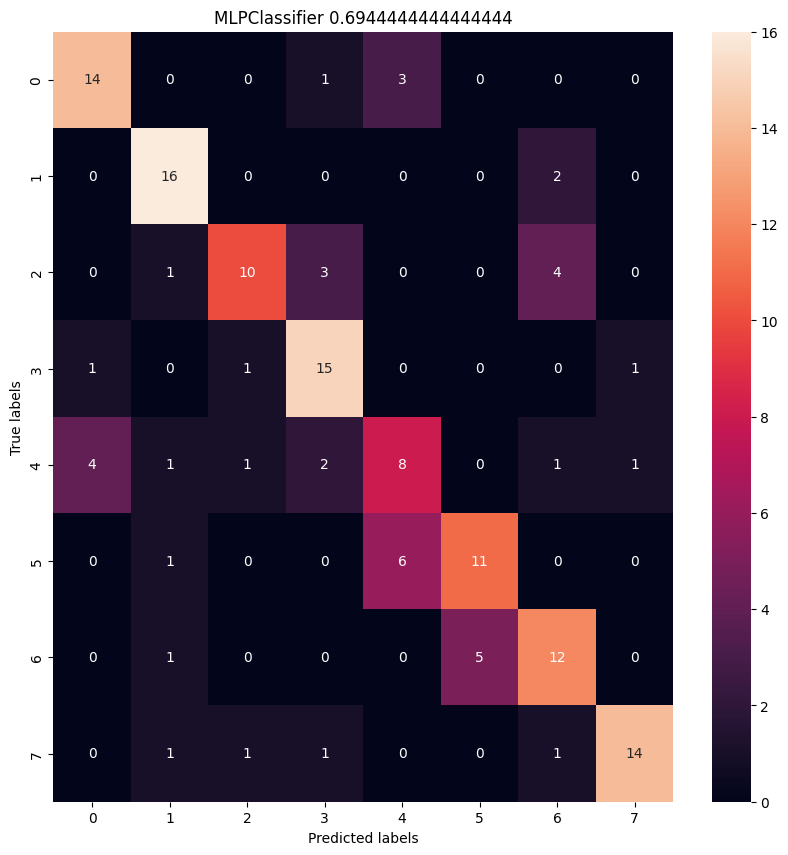

KNeighborsClassifier 0.6527777777777778


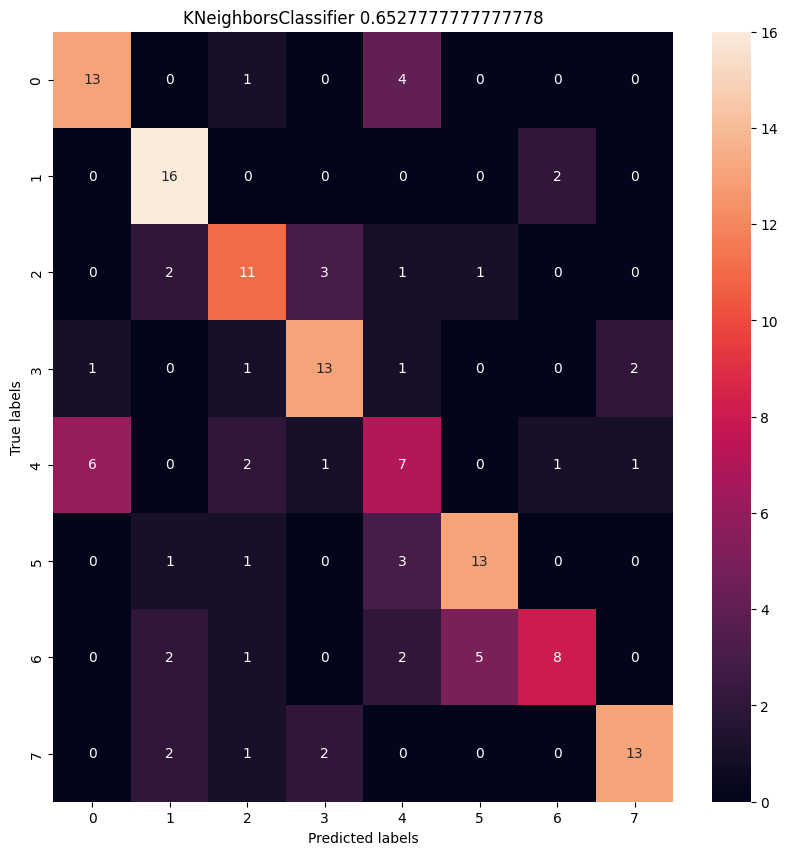

In [28]:
# Clasificadores
classifiers = [
    SVC(kernel="rbf", random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    KNeighborsClassifier(8),
]


# Entrenamiento y evaluación
for clf in classifiers:
    clf.fit(train_data, train_labels)
    score = clf.score(test_data, test_labels)
    print(f"{clf.__class__.__name__} {score}")

    # Confusion matrix  
    y_pred = clf.predict(test_data)
    cm = confusion_matrix(test_labels, y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f"{clf.__class__.__name__} {score}")
    plt.show()


